In [1]:
from Define_Model.FilterLayer import FreqTimeReweightLayer, get_weight
import torch
import kaldiio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

import pandas as pd
import json
import os
import h5py
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import metrics
%matplotlib inline

/home/yangwenhao/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lstm_path = '/home/yangwenhao/project/lstm_speaker_verification'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch/Data/gradient'

In [3]:
def read_hdf5(reader, key):
    with h5py.File(reader, 'r') as r:
        data_flat = r.get(key)[:]
        return data_flat

In [4]:
def input_reprocessing(data, grad, threshold=0.15, pro_type='del', init_input='zero'):
    H, W = data.shape
    if init_input == 'zero':
        start = np.zeros(data.shape)
    elif init_input == 'mean':
        start = np.tile(np.mean(data, axis=0), (data.shape[0], 1))
        
    final = data.copy()

    if pro_type == 'insert':
        salient_order = np.flip(np.argsort(grad.reshape(H*W)), axis=0)
    elif pro_type == 'del':
        salient_order = np.argsort(grad.reshape(H*W))
        threshold = 1 - threshold
    
    coords = salient_order[0:int((H*W)*threshold)]
    start.reshape(H*W)[coords] = final.reshape(H*W)[coords]

    return start

In [5]:
def plot_cam(model_path, cam_methold, epoch, plot_type, json_path=None,
             init_input='mean', norm_cam='none', alpha=1):
    """
    """
    if json_path == None:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    
    result_file_suffix = ''
    
    if init_input != 'zero':
        result_file_suffix += '.' + init_input
    
    if norm_cam != 'none':
        result_file_suffix += '.' + norm_cam
        
    json_path += 'result{}.json'.format(result_file_suffix)
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            result = json.load(f)

        xy = []
        for mask_type, threshold, acc in result:
            if mask_type == plot_type:
                xy.append([threshold, acc])
    
        if len(xy) > 0:
            xy = np.array(xy)
            x_idx = np.argsort(xy[:, 0])
            xy = xy[x_idx]
            # print(xy[:,0][-3:])
            plt.plot(xy[:,0]*100, xy[:,1], alpha=alpha)
            auc = metrics.auc(xy[:,0], xy[:,1]/100)
            leg_str = "{}:{:.4f}".format(cam_methold+result_file_suffix, auc)
            return [leg_str]
    
    print('Skip {} ...'.format(cam_methold))
    return []

In [ ]:
model_path = 'ThinResNet34/Mean_batch128_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb80_dist2/123456'
epoch = 26

In [6]:
model_path = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist/123456'
epoch = 19

In [ ]:
# cam_methold = 'layer_cam'
# model_path = 'ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456'

legs = ['insert', 'del']
plot_type = 'insert'
init_input ='mean' # zero
norm_cam = 'none'

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))


plt.figure(figsize=(7, 6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, plot_type, json_path=json_path, init_input=init_input)
    plt_cams.extend(plt_leg)

plt_cams =[p.replace('.mean', '') for p in plt_cams]
plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Insertion Proportion (%)')
plt.legend(plt_cams)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在使用insertion的方法进行不同saliency map进行比较Top-1 Acc时， AUC的大小顺序是：
# Integrad > layer_cam > gradient > fullgrad >> grad_cam_pp > grad_cam
# 由此可得： 包含输入梯度的saliency map提取方法相对准确一些，grad_cam和grad_cam_pp
# 表现明显较其他方法更差，原因在于没有考虑输入或者在降采样后的特征和梯度上提取saliency map
# 再进行的升采样，这一过程恐怕伴随不少信息丢失。

In [ ]:
auc_xy_insert =[p.split(":") for p in plt_cams]
xs, ys = [], []

for x,y in auc_xy_insert:
    y = float(y)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)
y_sort_idx = np.argsort(ys)

pdf = PdfPages(save_dir + '/{}.bar.pdf'.format(save_name))

plt.figure(figsize=(4, 4))

for i,j in zip(xs[y_sort_idx], ys[y_sort_idx]):
    plt.bar(i, j)
    
_ = plt.xticks(rotation=60)
plt.ylim([0.35, 0.8])
plt.ylabel('AUC')
plt.tight_layout()

pdf.savefig()
pdf.close()

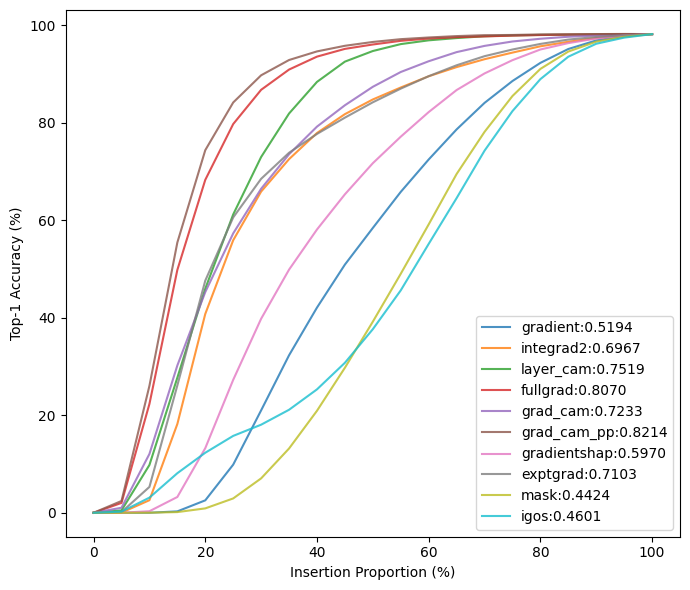

In [16]:
legs = ['insert', 'del']
plot_type = 'insert'
init_input='mean' # zero
norm_cam = 'time'
train_set = 'vox2'
alpha = .8

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))

plt.figure(figsize=(7, 6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, epoch, plot_type, norm_cam=norm_cam,
                       json_path=json_path, init_input=init_input, alpha=alpha)
    plt_cams.extend(plt_leg)

plt_cams =[p.replace('.mean.time', '') for p in plt_cams]

plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Insertion Proportion (%)')
plt.legend(plt_cams, fontsize=10)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在使用insertion的方法进行不同saliency map进行比较Top-1 Acc时， AUC的大小顺序是：
# Integrad > layer_cam > gradient > fullgrad >> grad_cam_pp > grad_cam
# 由此可得： 包含输入梯度的saliency map提取方法相对准确一些，grad_cam和grad_cam_pp
# 表现明显较其他方法更差，原因在于没有考虑输入或者在降采样后的特征和梯度上提取saliency map
# 再进行的升采样，这一过程恐怕伴随不少信息丢失。

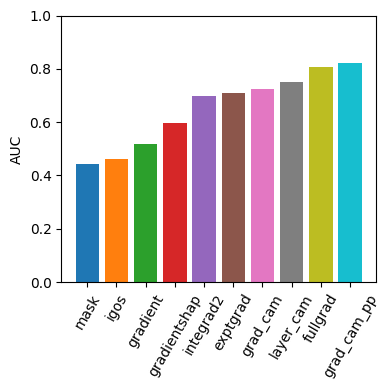

In [17]:
auc_xy_insert =[p.split(":") for p in plt_cams]
xs, ys = [], []

for x,y in auc_xy_insert:
    y = float(y)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)
y_sort_idx = np.argsort(ys)

pdf = PdfPages(save_dir + '/{}.bar.pdf'.format(save_name))

plt.figure(figsize=(4, 4))

for i,j in zip(xs[y_sort_idx], ys[y_sort_idx]):
    plt.bar(i, j)
    
_ = plt.xticks(rotation=60)
plt.ylim([0., 1])
plt.ylabel('AUC')

plt.tight_layout()

pdf.savefig()
pdf.close()

In [ ]:
legs = ['insert', 'del']
plot_type = 'insert'
init_input='mean' # zero
norm_cam = 'freq'
train_set = 'vox1'
alpha = .8

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))

plt.figure(figsize=(7, 6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, plot_type, norm_cam=norm_cam,
                       json_path=json_path, init_input=init_input, alpha=alpha)
    plt_cams.extend(plt_leg)

plt_cams =[p.replace('.mean.time', '') for p in plt_cams]

plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Insertion Proportion (%)')
plt.legend(plt_cams, fontsize=10)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在使用insertion的方法进行不同saliency map进行比较Top-1 Acc时， AUC的大小顺序是：
# Integrad > layer_cam > gradient > fullgrad >> grad_cam_pp > grad_cam
# 由此可得： 包含输入梯度的saliency map提取方法相对准确一些，grad_cam和grad_cam_pp
# 表现明显较其他方法更差，原因在于没有考虑输入或者在降采样后的特征和梯度上提取saliency map
# 再进行的升采样，这一过程恐怕伴随不少信息丢失。

In [ ]:
legs = ['insert', 'del']
plot_type = 'del'
init_input='mean' # zero
norm_cam = 'none'
train_set = 'vox1'

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))

plt.figure(figsize=(7, 6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, plot_type, norm_cam=norm_cam,
                       json_path=json_path, init_input=init_input)
    plt_cams.extend(plt_leg)
    
plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Deletion Proportion (%)')
plt.legend(plt_cams, fontsize=10)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在Deletion实验中，AUC的顺序和Insertion的大体一致，我们可以发现：
# Integrad < gradient <layer_cam << grad_cam_pp < fullgrad < grad_cam
# 综合两次实验，可以看到
# Integrad方法表现是较好的；
# 和insertion实验结果不同的是，fullgrad方法在这里也相对于gradient、integrad、layer_cam方法差异较大；
# layer_cam方法和在此处差于gradient方法。

In [ ]:
auc_xy_delete =[p.split(":") for p in plt_cams]
xs, ys = [], []

for x,y in auc_xy_delete:
    y = float(y)
    xs.append(x.split('.')[0])
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)
y_sort_idx = np.argsort(-ys)
pdf = PdfPages(save_dir + '/{}.bar.pdf'.format(save_name))

plt.figure(figsize=(4, 4))
for i,j in zip(xs[y_sort_idx], ys[y_sort_idx]):
    plt.bar(i, j)
    
_ = plt.xticks(rotation=60)
plt.ylim([0., 0.55])
plt.ylabel('AUC')
plt.tight_layout()

pdf.savefig()
pdf.close()

Skip gradientshap ...


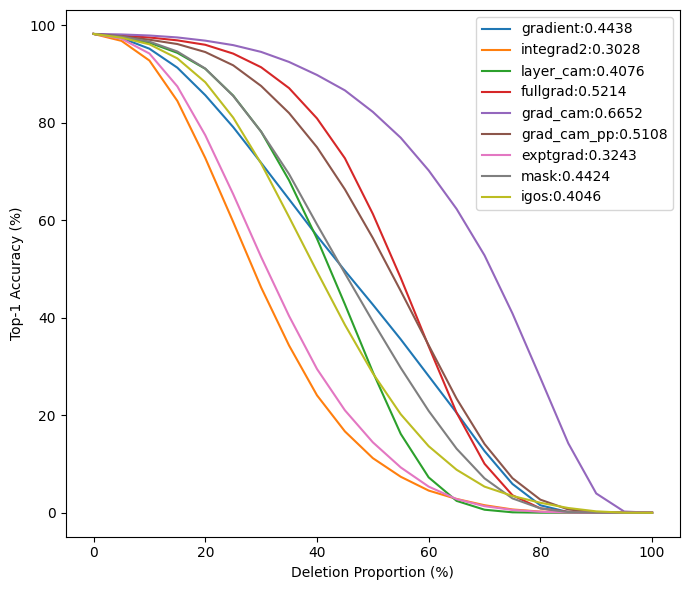

In [10]:
legs = ['insert', 'del']
plot_type = 'del'
init_input='mean' # zero
norm_cam = 'time'
train_set = 'vox2'

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))

plt.figure(figsize=(7, 6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, epoch, plot_type, norm_cam=norm_cam,
                       json_path=json_path, init_input=init_input)
    plt_cams.extend(plt_leg)

plt_cams =[p.replace('.mean.time', '') for p in plt_cams]

plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Deletion Proportion (%)')
plt.legend(plt_cams, fontsize=10)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在Deletion实验中，AUC的顺序和Insertion的大体一致，我们可以发现：
# Integrad < gradient <layer_cam << grad_cam_pp < fullgrad < grad_cam
# 综合两次实验，可以看到
# Integrad方法表现是较好的；
# 和insertion实验结果不同的是，fullgrad方法在这里也相对于gradient、integrad、layer_cam方法差异较大；
# layer_cam方法和在此处差于gradient方法。

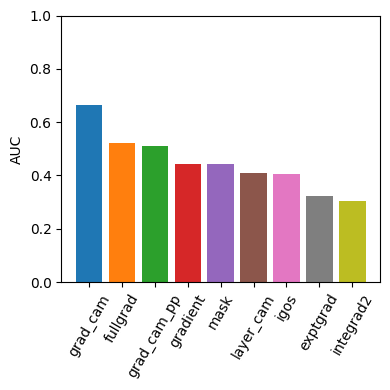

In [14]:
auc_xy_delete =[p.split(":") for p in plt_cams]
xs, ys = [], []

for x,y in auc_xy_delete:
    y = float(y)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)
y_sort_idx = np.argsort(-ys)
pdf = PdfPages(save_dir + '/{}.bar.pdf'.format(save_name))

plt.figure(figsize=(4, 4))
for i,j in zip(xs[y_sort_idx], ys[y_sort_idx]):
    plt.bar(i, j)
    
_ = plt.xticks(rotation=60)
plt.ylim([0.0, 1])
plt.ylabel('AUC')
plt.tight_layout()

pdf.savefig()
pdf.close()

Skip layer_cam ...
Skip gradientshap ...
Skip exptgrad ...


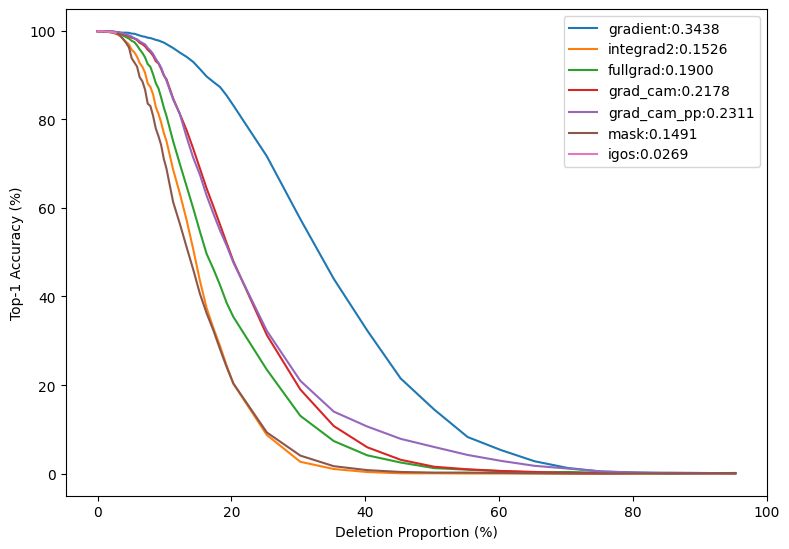

In [17]:
model_path = 'ThinResNet34/Mean_batch128_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/vox1/wave_fb80_dist2/123456'
epoch = 26

legs = ['insert', 'del']
plot_type = 'del'
init_input='mean' # zero
norm_cam = 'freq'
train_set = 'vox1'

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_name = '{}.{}.{}'.format(train_set, norm_cam, plot_type)
pdf = PdfPages(save_dir + '/{}.pdf'.format(save_name))

plt.figure(figsize=(7, 5.6))
cam_metholds = ['gradient', 'integrad2', 'layer_cam', 'fullgrad', 'grad_cam', 'grad_cam_pp', 'gradientshap', 'exptgrad', 'mask', 'igos']
plt_cams = []
for cam_methold in cam_metholds:
    if cam_methold in cam_metholds:
        json_path = root_path + '/{}/epoch_{}_var/{}_soft/'.format(model_path, epoch, cam_methold)
    else:
        json_path = None
        
    plt_leg = plot_cam(model_path, cam_methold, plot_type, norm_cam=norm_cam,
                       json_path=json_path, init_input=init_input)
    plt_cams.extend(plt_leg)

plt_cams =[p.replace('.mean.freq', '') for p in plt_cams]

plt.ylabel('Top-1 Accuracy (%)')
plt.xlabel('Deletion Proportion (%)')
plt.legend(plt_cams, fontsize=10)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 在Deletion实验中，AUC的顺序和Insertion的大体一致，我们可以发现：
# Integrad < gradient <layer_cam << grad_cam_pp < fullgrad < grad_cam
# 综合两次实验，可以看到
# Integrad方法表现是较好的；
# 和insertion实验结果不同的是，fullgrad方法在这里也相对于gradient、integrad、layer_cam方法差异较大；
# layer_cam方法和在此处差于gradient方法。

[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.94 0.96 0.98]
[0.9  0.95 1.  ]


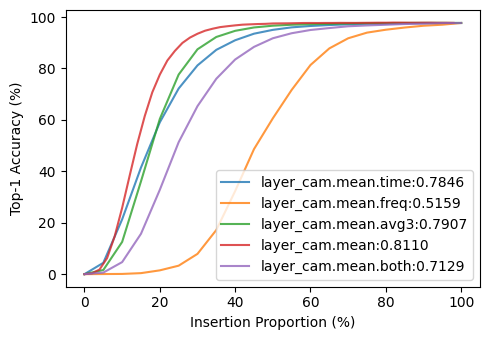

In [312]:
# cam_methold = 'layer_cam'
model_path = 'ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456'

legs = ['insert', 'del']
plot_type = 'insert'
init_input='mean' # zero
alpha = .8

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
pdf = PdfPages(save_dir + '/{}_norm.pdf'.format(plot_type))

plt.figure(figsize=(5, 3.5))
cam_methold = 'layer_cam'
plt_cams = []

for norm_cam in ['time', 'freq', 'avg3', 'none', 'both']:
    json_path = '../../Data/gradient/{}/epoch_41_var/{}_soft/'.format(model_path, cam_methold)
    
    plt_leg = plot_cam(model_path, cam_methold, plot_type,
                       json_path=json_path, init_input=init_input,
                       norm_cam=norm_cam,
                       alpha=alpha)
    plt_cams.extend(plt_leg)

# plt.xlim([-1, 1])
plt.ylabel('Top-1 Accuracy (%)')
if plot_type == 'del':
    plt.xlabel('Deletion Proportion (%)')
else:
    plt.xlabel('Insertion Proportion (%)')

plt.legend(plt_cams)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 使用不同saliency map的归一化方式，会严重影响实验的AUC结果
# 并且 AUC的值变化为以下顺序：(Insertion中AUC越大则越好)
# no_norm > avg_3 > freq > time
# 认为此处有探究这些差异，而不是使用time归一化的必要。

[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.9  0.95 1.  ]
[0.9  0.95 1.  ]


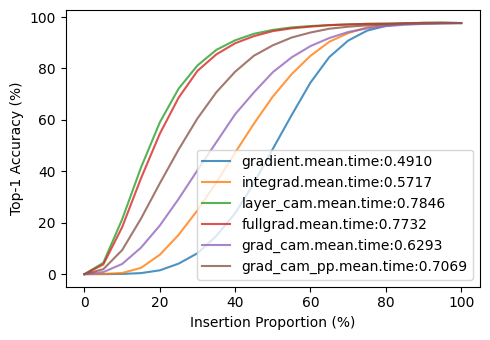

In [85]:
# cam_methold = 'layer_cam'
model_path = 'ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456'

legs = ['insert', 'del']
plot_type = 'insert'
init_input='mean' # zero
alpha = .8

save_dir = 'gfa/' + init_input #cam_methold
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
pdf = PdfPages(save_dir + '/{}.time.norm.pdf'.format(plot_type))

plt.figure(figsize=(5, 3.5))
cam_methold = 'layer_cam'
plt_cams = []
norm_cam = 'time'

# for norm_cam in ['time', 'freq', 'avg3', 'none', 'both']:
for cam_methold in cam_metholds:
    json_path = '../../Data/gradient/{}/epoch_41_var/{}_soft/'.format(model_path, cam_methold)
    
    plt_leg = plot_cam(model_path, cam_methold, plot_type,
                       json_path=json_path, init_input=init_input,
                       norm_cam=norm_cam,
                       alpha=alpha)
    plt_cams.extend(plt_leg)

# plt.xlim([-1, 1])
plt.ylabel('Top-1 Accuracy (%)')
if plot_type == 'del':
    plt.xlabel('Deletion Proportion (%)')
else:
    plt.xlabel('Insertion Proportion (%)')

plt.legend(plt_cams)
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

# 使用不同saliency map的归一化方式，会严重影响实验的AUC结果
# 并且 AUC的值变化为以下顺序：(Insertion中AUC越大则越好)
# no_norm > avg_3 > freq > time
# 认为此处有探究这些差异，而不是使用time归一化的必要。

In [145]:
result_file1 = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_gradient_soft/epoch_41/result.mean.json'

with open(result_file1, 'r') as f:
    results1 = json.load(f)

In [146]:
result_file2 = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var/gradient_soft/result.mean.json'

with open(result_file2, 'r') as f:
    results2 = json.load(f)

In [150]:
for i in results1:
    if i[0] == 'del':
        results2.append(i)

In [154]:
result_file2 = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var/gradient_soft/result.mean.json'

with open(result_file2, 'w') as f:
     json.dump(results2, f)

In [65]:
1/161

0.006211180124223602

In [84]:
from Misc.analysis import format_eer_file, read_eer_file, format_eer_file_train, format_eer_file_eval

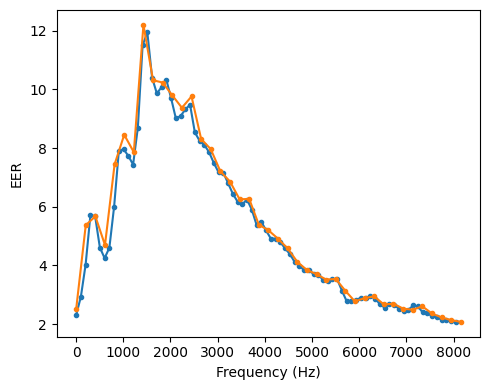

In [157]:
legs = ['insert', 'del']
pdf = PdfPages('gfa/pertub.pdf')

plt.figure(figsize=(5, 4))
pos_idx = {'EER':0, 'MinDCF':1, 'MinDCF':2}
eval_str = 'EER'
i = pos_idx[eval_str]

for mask_len in [2, 4]:
    # mask_len = 2
    result_idx, result_lst = read_eer_file('../data/freq_mask%d.txt'%mask_len)
    x = np.arange(161/mask_len) * 8000 / (161/mask_len - 1)
    
    eer_lift = result_lst[:161, i] #-norm_eer[i])/norm_eer[i]
    plt.plot(x, eer_lift, marker = '.')

plt.ylabel(eval_str)
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

pdf.savefig()
pdf.close()
# plt.legend(legs)

In [93]:
data_f = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/vox2_dev4/data.h5py'
data = read_hdf5(data_f, 'id00018-31xSZXsKR9w-00002')             
print(data.shape)

(3429, 161)


In [94]:
grad_f = '../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var/gradient_soft/grad.h5py'
grad = read_hdf5(grad_f, 'id00018-31xSZXsKR9w-00002')             
print(grad.shape)

(3428, 161)


In [41]:
data = np.random.randn(161, 161)

start = np.mean(data, axis=0, keepdims=True)
start = np.tile(start, (data.shape[0], 1))

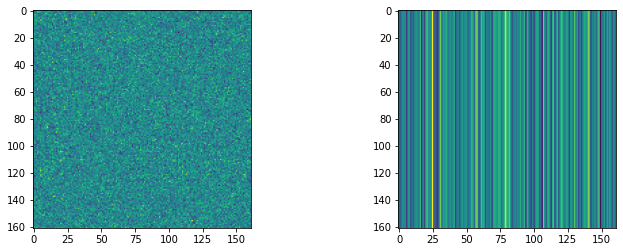

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(data)

plt.subplot(1,2,2)
plt.imshow(start)

In [6]:
test_json = pd.read_json("../../Data/gradient/ThinResNet34_ser06/Mean_batch256_basic_downk1_avg5_SAP2_em256_dp01_alpha0_none1_wde5_var/arcsoft_sgd_rop/vox2/123456/epoch_41_var_layer_cam_soft/epoch_41/label_pred.insert.0.0100.json")

In [9]:
test_json.tail()

,label,predict
96,[24],"[0.0001658184, 0.00021770670000000001, 0.00014..."
97,[24],"[0.0001615834, 0.00021756140000000001, 0.00014..."
98,[24],"[0.0001535962, 0.00021634640000000002, 0.00014..."
99,[24],"[0.0001571397, 0.000214591, 0.0001441630000000..."
100,accuracy,0.0


In [12]:
'{:<8s} {:>6.4f} {:>8.4f}'.format("insert", 0.01, 97)

'insert   0.0100  97.0000'

In [13]:
with open('test.json', 'r') as f:
    test = json.load(f)

In [15]:
test['test'] = [1,2]

In [16]:
with open('test.json', 'w') as f:
    json.dump(test, f)

In [164]:
x = torch.randn(2, 1, 12, 12)
y = torch.randn(24, 24)
print(y.shape[-2:])

torch.Size([24, 24])


In [134]:
torch.nn.functional.interpolate(x, size=y.shape[-2:], mode='bilinear', align_corners=True)

tensor([[[[-1.4088, -0.9901, -0.5714,  ...,  0.4169,  0.1777, -0.0614],
          [-1.1634, -0.8314, -0.4995,  ..., -0.0732,  0.1142,  0.3016],
          [-0.9180, -0.6727, -0.4275,  ..., -0.5634,  0.0506,  0.6646],
          ...,
          [ 2.2314,  1.0747, -0.0820,  ..., -0.9423,  0.3361,  1.6145],
          [ 1.1702,  0.8039,  0.4376,  ..., -1.3995, -0.5343,  0.3310],
          [ 0.1091,  0.5331,  0.9571,  ..., -1.8567, -1.4047, -0.9526]]],


        [[[-0.1124,  0.2313,  0.5750,  ...,  0.3374,  0.1778,  0.0182],
          [ 0.1892,  0.7724,  1.3556,  ..., -0.2371,  0.0973,  0.4317],
          [ 0.4908,  1.3135,  2.1362,  ..., -0.8116,  0.0168,  0.8452],
          ...,
          [-0.9055, -0.2954,  0.3148,  ..., -0.7009,  0.1115,  0.9240],
          [-0.2291,  0.2948,  0.8187,  ..., -0.3804, -0.4148, -0.4492],
          [ 0.4472,  0.8849,  1.3226,  ..., -0.0600, -0.9411, -1.8223]]]])

In [117]:
ups = torch.nn.UpsamplingBilinear2d(size=(300, 161))

In [122]:
print(ups.size)

(300, 161)


In [136]:
print('\nLoading model check yaml from: \n\t{}'.format('Data/checkpoint/ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/model.2023.05.08.yaml'.lstrip('Data/checkpoint/')))


Loading model check yaml from: 
	ThinResNet34/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/model.2023.05.08.yaml


In [167]:
torch.tensor([x.shape[-1]]*len(x))

tensor([12, 12])

In [165]:
x.shape

torch.Size([2, 1, 12, 12])

In [233]:
a = [[i,i+1] for i in range(20)]

In [236]:
f = open('test', 'r+')
test = json.load(f)

In [239]:
test['10'] = 10

In [240]:
f.seek(0)

0

In [241]:
json.dump(test, f)

In [242]:
f.close()

In [ ]:
f = open('test', 'r+')
test = json.load(f)

In [260]:
grad = np.random.randn(126, 161)

In [297]:
time_dim = grad.shape[-2]
freq_dim = grad.shape[-1]

grad_f = np.sum(grad, axis=0)
grad_t = np.sum(grad, axis=1)

# grad_f = np.sum(grad, axis=0, keepdims=True)
# grad_t = np.sum(grad, axis=1, keepdims=True)

cam_min, cam_max = grad_f.min(), grad_f.max()
pre_cam_f = np.tile((grad_f - cam_min) / (cam_max - cam_min + 1e-8), (time_dim, 1))

cam_min, cam_max = grad_t.min(), grad_t.max()
pre_cam_t = np.tile((grad_t - cam_min) / (cam_max - cam_min + 1e-8), (1, freq_dim))

print(np.flip(np.argsort(pre_cam_t.reshape(-1)))[:10], np.flip(np.argsort(pre_cam_f.reshape(-1)))[:10])

[18502 11950  7162 11572  7036 16990  6910  1114 11698  6784] [ 4229 17270 14533 18397  3102 10669 16465  3746  8737  9703]


In [268]:
print(time_dim, freq_dim)

126 161


In [269]:
print(pre_cam_f.shape, pre_cam_t.shape)

(126, 161) (1, 20286)


In [270]:
# keepdim
# [17066 17067 17125 17124 17123 17122 17121 17120 17119 17118] [ 4229 17270 14533 18397  3102 10669 16465  3746  8737  9703]

# sum
# [18502 11950  7162 11572  7036 16990  6910  1114 11698  6784] [ 4229 17270 14533 18397  3102 10669 16465  3746  8737  9703]

# keepdim 对freq归一化没有影响

array([18502, 11950,  7162, ...,  5549,   131, 12101])

In [1]:
import torch.nn.functional as F

In [40]:
grad = torch.randn(1,24,24)
data = torch.randn(1,48,48)
ups = torch.nn.UpsamplingBilinear2d(size=data.shape[-2:])

In [18]:
inte_grad = F.interpolate(grad.unsqueeze(0), size=data.shape[-2:],
                              mode='bilinear', align_corners=True)

up_grad = ups(grad.unsqueeze(0))

In [21]:
(inte_grad != up_grad).sum()

tensor(0)

In [23]:
F.pad(grad, (1,1,1,1), "constant", 0).shape

torch.Size([1, 26, 26])

In [64]:
stdev = 0.15 * (data.max(dim=1, keepdim=True).values - data.min(dim=1, keepdim=True).values)

torch.normal(torch.zeros_like(data), stdev.repeat(1,data.shape[-2],1)).shape

torch.Size([1, 48, 48])

In [62]:
print(stdev.shape)
print(stdev.repeat(1,data.shape[-2],1).shape)


torch.Size([1, 1, 48])
torch.Size([1, 48, 48])


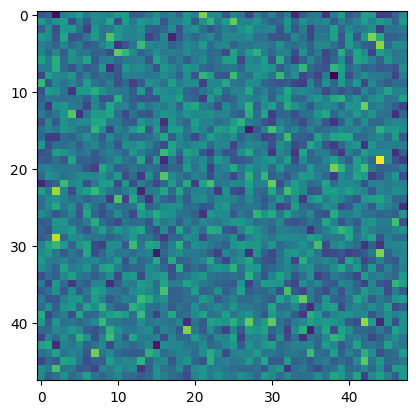

In [66]:
plt.imshow(torch.normal(torch.zeros_like(data), stdev.repeat(1,data.shape[-2],1)).squeeze())

In [46]:
torch.max(data, dim=1).values.shape

torch.Size([1, 48])

In [67]:
data = torch.randn(1, 1, 300, 80)
torch.cat([data, data], dim=-2).shape

torch.Size([1, 1, 600, 80])

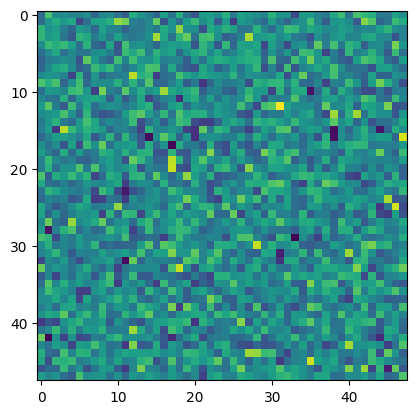

In [33]:
plt.imshow(torch.normal(torch.zeros_like(data), stdev*torch.ones_like(data)).squeeze())